In [1]:
import pandas as pd

In [2]:
"""
En este paso filtramos el dataset de alumnos por el año 2016 y hacemos join con el dataset de escuelas.
Luego eliminamos NULLs y grabamos el file df_final.csv. Pensando en predecir el campo nivel_desemp_matematica, 
lo transofrmamos en dos categorias, SATIFACTORIO con valor 0 (satifactorio y avanzado) y 1 BÁSICO (básico y por debajo de básico).
Para ejecutar este paso deben tener en la carpeta /desafio3/datasets , los datasets app_alumno.csv y app_escuela.csv.
"""

import pandas as pd
df = pd.read_csv('../desafio3/datasets/app_alumno.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_escuelas = pd.read_csv('../desafio3/datasets/app_escuela.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df = df[(df['nivel_desemp_matematica'].notnull()) & (df['year_id'] == 2016)]
df = df.drop(['id','repeticion_secundaria','nivel_desemp_ciencias_sociales','nivel_desemp_ciencias_naturales','year_id'], axis=1)
df = df.dropna(axis=0)
df['nivel_desemp_matematica'] = df['nivel_desemp_matematica'].apply(lambda x: 0 if x in ['satisfactorio','avanzado'] else 1)
df_escuelas = df_escuelas.rename(columns={'id': 'escuela_id'})
df_escuelas = df_escuelas.drop('icse_cat', axis=1)
df = df.merge(df_escuelas, how='inner', on ='escuela_id')
df = df.dropna(axis=0)
print('#######SHAPE:','\n',df.shape,'\n','#######','\n')
print('#######VALUE_COUNTS:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
print('#######NULLs:','\n',(df.isnull().sum()/df.shape[0])*100,'\n','#######','\n')
print('#######BALANCE:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
df.to_csv('../desafio3/datasets/df_final.csv')

FileNotFoundError: ignored

In [77]:
"""
En este paso, levantamos el nuevo dataset y convertimos al tipo de dato category las columnas que consideramos categoricas
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [78]:
df = pd.read_csv('df_final.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df = df.drop('Unnamed: 0', axis=1)
# -----------------------------------------------
# Agrego el data set de sueldo por provincia
# -----------------------------------------
sueldos = pd.read_csv("csv_files_app_salario.csv",low_memory=False)
sueldos = sueldos[(sueldos.year_id == 2016)]
sueldos = sueldos[(sueldos.name == "maestro_inicial") | (sueldos.name == "maestro_de_grado") | (sueldos.name == "director_primaria")]
sueldos_listo = pd.pivot_table(sueldos,values="value",columns="name",index="provincia_id")
df = pd.merge(df,sueldos_listo,how="left",left_on="provincia_id",right_index=True)
for i in df.columns:
    if (df[i].dtype == object) or i in ['nivel_id', 'escuela_id', 'provincia_id', 'departamento_id','director_primaria','maestro_inicial']:
      # -------------------------------------------------------------
      # Agrego las 3 columnas que se refieren a los sueldos de las diferentes posiciones
      # ---------------------------------------------------------------
        df[i] = pd.Categorical(df[i])
df.head()

,sexo,indice_socioeconomico,nivel_desemp_matematica,nivel_desemp_lengua,ponderador_lengua,ponderador_matematica,ponderador_ciencias_naturales,ponderador_ciencias_sociales,tiene_notebook,tiene_pc,tiene_tablet,tiene_celular,tiene_smartphone,tiene_consola,tiene_smarttv,tiene_cable,tiene_internet_x,repeticion_primaria,escuela_id,nivel_id,ambito,gestion,icse,indice_socioeconomico_medio,indice_socioeconomico_medio_cat,tecnica,tiene_internet_y,subvencion,dependencia,departamento_id,provincia_id,director_primaria,maestro_de_grado,maestro_inicial
0,f,medio,0,avanzado,1.309467,1.308268,-1.0,-1.0,no,si,si,si,no,no,no,si,si,no,220564311,2,urbano,privada,-1.0,2.21978,tercil_alto,f,t,Subvención Total,provincial,89.0,4.0,27996.25,11744.66,11744.66
1,f,alto,0,avanzado,1.309467,1.308268,-1.0,-1.0,si,si,no,si,no,si,si,no,si,no,220564311,2,urbano,privada,-1.0,2.21978,tercil_alto,f,t,Subvención Total,provincial,89.0,4.0,27996.25,11744.66,11744.66
2,m,medio,0,satisfactorio,1.309467,1.308268,-1.0,-1.0,si,si,si,si,no,no,si,si,si,no,220564311,2,urbano,privada,-1.0,2.21978,tercil_alto,f,t,Subvención Total,provincial,89.0,4.0,27996.25,11744.66,11744.66
3,m,medio,0,avanzado,1.309467,1.308268,-1.0,-1.0,no,si,no,si,no,si,si,si,si,no,220564311,2,urbano,privada,-1.0,2.21978,tercil_alto,f,t,Subvención Total,provincial,89.0,4.0,27996.25,11744.66,11744.66
4,m,medio,0,avanzado,1.309467,1.308268,-1.0,-1.0,si,si,si,no,no,no,no,no,si,no,220564311,2,urbano,privada,-1.0,2.21978,tercil_alto,f,t,Subvención Total,provincial,89.0,4.0,27996.25,11744.66,11744.66


In [79]:
# ---------------------
# para ver los nulos
def pct_nulos(data):
  return data.isnull().sum() / data.shape[0]
pct_nulos(df)

sexo                               0.000000
indice_socioeconomico              0.000000
nivel_desemp_matematica            0.000000
nivel_desemp_lengua                0.000000
ponderador_lengua                  0.000000
ponderador_matematica              0.000000
ponderador_ciencias_naturales      0.000000
ponderador_ciencias_sociales       0.000000
tiene_notebook                     0.000000
tiene_pc                           0.000000
tiene_tablet                       0.000000
tiene_celular                      0.000000
tiene_smartphone                   0.000000
tiene_consola                      0.000000
tiene_smarttv                      0.000000
tiene_cable                        0.000000
tiene_internet_x                   0.000000
repeticion_primaria                0.000000
escuela_id                         0.000000
nivel_id                           0.000000
ambito                             0.000000
gestion                            0.000000
icse                            

In [80]:
# -------------------------------------------------------------
# Creo los ponderadores para matematica y lengua. Ademas elimino algunas variables irrelevantes para el modelo
df.columns
ponderador_mate = df.ponderador_matematica
ponderador_lengua = df.ponderador_lengua
df.drop(columns=['ponderador_lengua', 'ponderador_matematica','ponderador_ciencias_naturales', 'ponderador_ciencias_sociales'],inplace = True)

In [81]:

"""A continuación ejecutamos modelos de regresión logistica para validar que el dataset final sea adecuado para trabajar .
"""
# ---------------------------------------------------
# elimino algunos nulos que quedaros 
df.dropna(inplace=True)
# ------------------------------------------
X = df.drop('nivel_desemp_matematica', axis=1)
y = df['nivel_desemp_matematica']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)


In [82]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns = 'n'):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            #c para tomar columnas categoricas, cualquier otro valor para tomar continuas.
            if self.columns == 'c':
              # --------------------------------------------------
              # este codigo: pd.api.types.is_categorical_dtype(df[col])
              # Cambio en la ultima parte lo que era igual a df[col] por X[col]
              # Da el mismo resultado, pero ahora si le paso otro data frame no me va tirar error
              #  Tambien, lo cambio en el else
              # ----------------------------------------------------
                categorical_columns = [col for col in X.columns if pd.api.types.is_categorical_dtype(X[col])]
                return pd.DataFrame(X[categorical_columns])
            else:
                scal_columns = [col for col in X.columns if (pd.api.types.is_categorical_dtype(X[col]) == False)]
                return pd.DataFrame(X[scal_columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
cat_pipe = make_pipeline(ColumnSelector('c'),OneHotEncoder(handle_unknown='ignore'))
num_pipe = make_pipeline(ColumnSelector('n'),StandardScaler())
union = make_union(num_pipe,
                   cat_pipe)



In [83]:
#Este paso tarda bastante dado que ejecutamos un random grid search.
"""
RESULTADO: 
Best score: 0.739
Best parameters set:
	 log__C: 0.1
	 log__penalty: 'l2'
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     44028
           1       0.69      0.63      0.66     29395

    accuracy                           0.74     73423
   macro avg       0.73      0.72      0.72     73423
weighted avg       0.73      0.74      0.74     73423

0.7373302643585797
"""
# ---------------------------------
# Con los cambios que hice este fue el score
# Best score: 0.772
# Best parameters set:
# 	 log__C: 0.1
# 	 log__penalty: 'l2'
# 	 log__solver: 'saga'
#               precision    recall  f1-score   support

#            0       0.84      0.89      0.86       966
#            1       0.69      0.58      0.63       400

#     accuracy                           0.80      1366
#    macro avg       0.76      0.74      0.75      1366
# weighted avg       0.79      0.80      0.80      1366

# 0.801610541727672


#  el solver elegido saga, segun la documentación de sklearn funciona mejor para dasets grandes como el nuestro
# ---------------------------------------------------



union.fit_transform(X)
# -------------------------------------------------------
# para que la regresion logistica sea representativa de una poblacion se tienen que usar los ponderadores
# LogisticRegression(solver='liblinear').fit(X,y,class_weight="ponderador_matematica)
#  hay que ver como se lo agregamos al grid search ya que no me deja hacerlo 
# -----------------------------------------------------------



pipeline = Pipeline([('union', union), 
                     ('log', LogisticRegression(solver='liblinear'))])
# ----------------------------------------------
#  agrego solver para elegir 
parameters = {'log__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'log__penalty': ['l1', 'l2'],
              'log__C': [0.01, 0.1, 1, 10, 100]}
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(pipeline, parameters,cv=folds, n_jobs = 5)
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 
# -----------------------------------------------------------------------------
# habria que evitar usar los datos de testeo, primero probar con varios modelos, una vez elegido el modelo usar los datos de testeo
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Best score: 0.772
Best parameters set:
	 log__C: 0.1
	 log__penalty: 'l2'
	 log__solver: 'saga'
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       966
           1       0.69      0.58      0.63       400

    accuracy                           0.80      1366
   macro avg       0.76      0.74      0.75      1366
weighted avg       0.79      0.80      0.80      1366

0.801610541727672


In [88]:
#  Hago un grid search sobre el log__C al rededor de 0.1 que fue el parametro elegido
pipeline = Pipeline([('union', union), 
                    ('log', LogisticRegression(solver='saga',penalty='l2'))])
#  agrego solver para elegir 
parameters = {
    'log__C': np.linspace(0.01,1,30)
    }
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, parameters,cv=folds, n_jobs = 5)
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name]))

#  El score en el grid search mejoro un poco

Best score: 0.774
Best parameters set:
	 log__C: 0.38551724137931037


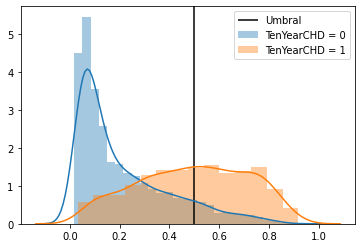

In [34]:
# Histograma de probabilidades para ver si cambiando el umbral de decición puedo mejorar el accuracy 
sns.distplot(grid_search.predict_proba(X_train[y_train==0])[:,1])
sns.distplot(grid_search.predict_proba(X_train[y_train==1])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'TenYearCHD = 0', 'TenYearCHD = 1'])

In [42]:
accuracy = []
for umbral in np.linspace(0.01,0.9,20):
  probabilidad = grid_search.predict_proba(X_train)[:,1]
  y_pred_proba = probabilidad > umbral
  accuracy.append([accuracy_score(y_train,y_pred_proba),umbral])
  print(f"umbral igual {umbral}:",accuracy_score(y_train,y_pred_proba))
print("mejor accuracy es",max(accuracy))
# Hay que tener en cuenta que al hacer esto podemos tener problemas de overfitting, 
# si lo hicieramos en un esquema de validacion cruzada seria mejor

umbral igual 0.01: 0.29240907981449843
umbral igual 0.056842105263157895: 0.4264095679765682
umbral igual 0.10368421052631578: 0.5684647302904564
umbral igual 0.15052631578947367: 0.6482792287039297
umbral igual 0.19736842105263158: 0.6927019770563827
umbral igual 0.2442105263157895: 0.7254088357334635
umbral igual 0.29105263157894734: 0.751769587503051
umbral igual 0.33789473684210525: 0.7661703685623628
umbral igual 0.38473684210526315: 0.7761776909934098
umbral igual 0.43157894736842106: 0.7844764461801318
umbral igual 0.47842105263157897: 0.7842323651452282
umbral igual 0.5252631578947369: 0.7852086892848426
umbral igual 0.5721052631578947: 0.7805711496216744
umbral igual 0.6189473684210526: 0.7703197461557237
umbral igual 0.6657894736842105: 0.7605565047595801
umbral igual 0.7126315789473684: 0.7512814254332438
umbral igual 0.7594736842105263: 0.7381010495484501
umbral igual 0.8063157894736842: 0.7232121064193312
umbral igual 0.8531578947368421: 0.7151574322675128
umbral igual 0.9

In [90]:
# -------------------------------------------------------
# para que la regresion logistica sea representativa de una poblacion se tienen que usar los ponderadores
# LogisticRegression(solver='liblinear').fit(X,y,class_weight="ponderador_matematica)

# -----------------------------------------------------------

pipeline = Pipeline([('union', union), 
                    ('modelo', KNeighborsClassifier())])
parameters = {'modelo__n_neighbors':[5,10,50,100,200,300,1000],
              'modelo__weights':['uniform','distance']}
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(pipeline, parameters,cv=folds, n_jobs = 5)
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 
y_pred_train = grid_search.best_estimator_.predict(X_train)
print("EN ENTRENAMIENTO \n",classification_report(y_train, y_pred_train))
print(accuracy_score(y_train, y_pred_train))

Best score: 0.749
Best parameters set:
	 modelo__n_neighbors: 50
	 modelo__weights: 'uniform'
EN ENTRENAMIENTO 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      2899
           1       0.66      0.33      0.44      1198

    accuracy                           0.75      4097
   macro avg       0.71      0.63      0.64      4097
weighted avg       0.74      0.75      0.72      4097

0.7534781547473761


In [105]:
# -----------------------------------------------
#  Ahora pruebo con un modelo naive bayes, como el union devuelve una matriz esparza primero lo aplico por fuera
#  y luego hago el grid search lo paso como array y busco entre dos modelo de tipo naive bayes 
# ---------------------------------------
X_train_union= union.fit_transform(X_train)
X_test_union= union.transform(X_test)

pipeline = Pipeline([('modelo', GaussianNB())])

parameters = {'modelo':[GaussianNB(),LinearDiscriminantAnalysis()]}

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, parameters,cv=folds, n_jobs = 5)
grid_search.fit(X_train_union.toarray(), y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name]))
y_pred = grid_search.best_estimator_.predict(X_train_union.toarray())
print("EN ENTRENAMIENTO: \n",classification_report(y_train, y_pred))
print("EN ENTRENAMIENTO",accuracy_score(y_train, y_pred))
resultados_NB = pd.DataFrame(grid_search.cv_results_)
#  Se ve el algoritmo linear discriminant analysis anda bien.
#  Aqui la documentación https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Best score: 0.769
Best parameters set:
	 modelo: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
EN ENTRENAMIENTO: 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      2899
           1       0.69      0.56      0.62      1198

    accuracy                           0.80      4097
   macro avg       0.76      0.73      0.74      4097
weighted avg       0.79      0.80      0.79      4097

EN ENTRENAMIENTO 0.7983890651696364


In [107]:
resultados_NB.iloc[:,4:]

,param_modelo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,"GaussianNB(priors=None, var_smoothing=1e-09)","{'modelo': GaussianNB(priors=None, var_smoothi...",0.454878,0.467073,0.478632,0.482295,0.492063,0.474989,0.012848,2
1,"LinearDiscriminantAnalysis(n_components=None, ...",{'modelo': LinearDiscriminantAnalysis(n_compon...,0.758537,0.763415,0.755800,0.780220,0.785104,0.768615,0.011827,1


### Comentarios
Era de esperase que el modelo gaussian_NB sean malo, ya que supone que las features no se correlacionan, cosa que es muy poco problable. Ya que un chico que se encuentra en una clase economicamente baja es de esperarse que no tenga celular, computadora y varios elementos mas que aparecen como variables dummy.
Por otra parte el algoritmo LinearDiscriminant Analysis funciona muy bien, llegando a resultados parecidos al de la regresión logistica en entrenamiento.


In [109]:
#evaluation - baselines
num_folds = 10
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results = cross_val_score(model,X_train_union.toarray(), y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR 0.776179 0.024170 
KNN 0.724443 0.024843 
CART 0.700273 0.035248 
SVM 0.764705 0.028605 


In [110]:
pipeline = Pipeline([('union', union), 
                     ('modelo', LogisticRegression(solver='liblinear'))])
#  agrego solver para elegir 
parameters = {'modelo':[
                        LogisticRegression(max_iter=1000),
                        KNeighborsClassifier(n_neighbors=100),
                        DecisionTreeClassifier(),
                        SVC()
]}
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, parameters,cv=folds, n_jobs = 5)
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

# habria que evitar usar los datos de testeo, primero probar con varios modelos, una vez elegido el modelo usar los datos de testeo
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Best score: 0.771
Best parameters set:
	 modelo: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       966
           1       0.70      0.61      0.65       400

    accuracy                           0.81      1366
   macro avg       0.77      0.75      0.76      1366
weighted avg       0.80      0.81      0.80      1366

0.8074670571010248


In [111]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.096066,0.227355,0.090740,0.010313,"LogisticRegression(C=1.0, class_weight=None, d...","{'modelo': LogisticRegression(C=1.0, class_wei...",0.758537,0.775610,0.755800,0.774115,0.789988,0.770810,0.012471,1
1,0.255232,0.028394,1.010517,0.077839,"KNeighborsClassifier(algorithm='auto', leaf_si...",{'modelo': KNeighborsClassifier(algorithm='aut...,0.737805,0.750000,0.758242,0.747253,0.753358,0.749331,0.006830,3
2,0.751470,0.053937,0.077109,0.014120,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{'modelo': DecisionTreeClassifier(ccp_alpha=0....,0.695122,0.724390,0.659341,0.675214,0.726496,0.696112,0.026505,4
3,4.864150,0.061229,1.022161,0.092686,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'modelo': SVC(C=1.0, break_ties=False, cache_...",0.757317,0.771951,0.755800,0.770452,0.777778,0.766660,0.008616,2
